In [1]:
"""
Filename: log_linear_growth_model.py
Authors: John Stachurski, Thomas Sargent

The log linear growth model, wrapped as classes.  For use with the
optgrowth.py module.
"""

import numpy as np
import matplotlib.pyplot as plt
#from optgrowth import bellman_operator
from quantecon import compute_fixed_point
from joblib import Memory
import seaborn as sns
from scipy.optimize import fminbound
from scipy import interp                                   # Fast but inaccurate
from scipy.interpolate import PchipInterpolator, interp1d  # Slow but accurate

memory = Memory(cachedir='./joblib_cache')
%matplotlib inline
sns.set_style('whitegrid')

In [6]:
def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    beta : scalar
        The discount factor
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty(len(w))

    if compute_policy:
        sigma = np.empty(len(w))

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [7]:
@memory.cache
def compute_value_function_cached(grid, ufunc, beta, alpha, shocks):
    """
    Compute the value function by iterating on the Bellman operator.
    The work is done by QuantEcon's compute_fixed_point function.
    """
    Tw = np.empty(len(grid))
    initial_w = 5 * np.log(grid) - 25

    v_star = compute_fixed_point(bellman_operator, 
            initial_w, 
            1e-4,  # error_tol
            100,   # max_iter
            True,  # verbose
            5,     # print_skip
            grid,
            beta,
            ufunc,
            lambda k: k**alpha,
            shocks,
            Tw=Tw,
            compute_policy=False)
    return v_star

In [8]:
pamdic = {"alpha":0.65,         # Productivity parameter
          "beta":0.95,          # Discount factor
          "mu":1,               # First parameter in lognorm(mu, sigma)
          "sigma":0.1,          # Second parameter in lognorm(mu, sigma)
          "grid_max":8, 
          "grid_size":150}
pamdic2 = pamdic.copy()
pamdic2['sigma']=0.6

grid = np.linspace(1e-6, pamdic["grid_max"], pamdic["grid_size"])

shocks = np.exp(pamdic["mu"] + pamdic["sigma"] * np.random.randn(250))
big_shocks = np.exp(pamdic["mu"] + pamdic2["sigma"] * np.random.randn(250))

In [9]:
v_star = compute_value_function_cached(grid,
                                       np.log,
                                       pamdic["beta"],
                                       pamdic["alpha"],
                                       shocks)

________________________________________________________________________________
[Memory] Calling __main__--Users-crisla-Documents-code-club-s3-__ipython-input__.compute_value_function_cached-alias...
compute_value_function_cached-alias(array([  1.000000e-06, ...,   8.000000e+00]), <ufunc 'log'>, 0.95, 0.65, array([ 2.476439, ...,  2.843238]))
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            7.792e+00      5.234e-01         
10           5.859e+00      9.716e-01         
15           4.409e+00      1.431e+00         
20           3.317e+00      1.884e+00         
25           2.495e+00      2.340e+00         
30           1.877e+00      2.801e+00         
35           1.412e+00      3.252e+00         
40           1.061e+00      3.711e+00         
45           7.981e-01      4.299e+00         
50           6.000e-01      4.785e+00         
55           4.509e-01      5.272e+00         
60           3.389e-01      5.821e+00        

In [10]:
v_star2 = compute_value_function_cached(grid,
                                       np.log,
                                       pamdic["beta"],
                                       pamdic["alpha"],
                                       big_shocks)

________________________________________________________________________________
[Memory] Calling __main__--Users-crisla-Documents-code-club-s3-__ipython-input__.compute_value_function_cached-alias...
compute_value_function_cached-alias(array([  1.000000e-06, ...,   8.000000e+00]), <ufunc 'log'>, 0.95, 0.65, array([ 8.006166, ...,  1.508464]))
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            7.752e+00      5.505e-01         
10           5.816e+00      1.069e+00         
15           4.366e+00      1.609e+00         
20           3.277e+00      2.217e+00         
25           2.459e+00      2.777e+00         
30           1.846e+00      3.292e+00         
35           1.385e+00      3.782e+00         
40           1.039e+00      4.381e+00         
45           7.792e-01      4.888e+00         
50           5.843e-01      5.460e+00         
55           4.382e-01      5.991e+00         
60           3.285e-01      6.514e+00        

In [11]:
def uRRA(c, rho=2):
    return (c**(1-rho)-1)/(1-rho)

In [12]:
v_CRRA = compute_value_function_cached(grid,
                                       uRRA,
                                       pamdic["beta"],
                                       pamdic["alpha"],
                                       shocks)

________________________________________________________________________________
[Memory] Calling __main__--Users-crisla-Documents-code-club-s3-__ipython-input__.compute_value_function_cached-alias...
compute_value_function_cached-alias(array([  1.000000e-06, ...,   8.000000e+00]), <function uRRA at 0x10e82b398>, 0.95, 0.65, array([ 2.476439, ...,  2.843238]))
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.092e+06      5.182e-01         
10           1.582e+06      9.900e-01         
15           1.195e+06      1.477e+00         
20           9.036e+05      1.934e+00         
25           6.830e+05      2.397e+00         
30           5.163e+05      2.869e+00         
35           3.902e+05      3.334e+00         
40           2.950e+05      3.797e+00         
45           2.229e+05      4.267e+00         
50           1.685e+05      4.765e+00         
55           1.274e+05      5.273e+00         
60           9.628e+04      

In [13]:
v_CRRARisky = compute_value_function_cached(grid,
                                       uRRA,
                                       pamdic["beta"],
                                       pamdic["alpha"],
                                       big_shocks)

________________________________________________________________________________
[Memory] Calling __main__--Users-crisla-Documents-code-club-s3-__ipython-input__.compute_value_function_cached-alias...
compute_value_function_cached-alias(array([  1.000000e-06, ...,   8.000000e+00]), <function uRRA at 0x10e82b398>, 0.95, 0.65, array([ 8.006166, ...,  1.508464]))
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.088e+06      5.220e-01         
10           1.574e+06      1.011e+00         
15           1.186e+06      1.502e+00         
20           8.944e+05      2.010e+00         
25           6.742e+05      2.572e+00         
30           5.083e+05      3.077e+00         
35           3.831e+05      3.544e+00         
40           2.888e+05      4.017e+00         
45           2.177e+05      4.506e+00         
50           1.641e+05      5.009e+00         
55           1.237e+05      5.510e+00         
60           9.326e+04      

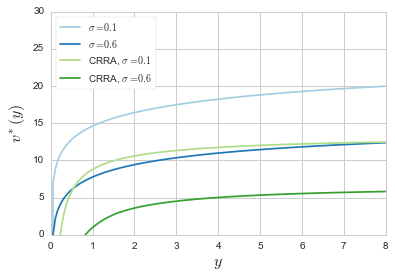

In [18]:
sns.set_palette(sns.color_palette("Paired"))
plt.plot(grid,v_star, label='$\sigma = 0.1$')
plt.plot(grid,v_star2, label='$\sigma = 0.6$')
plt.plot(grid,v_CRRA, label='CRRA, $\sigma = 0.1$')
plt.plot(grid,v_CRRARisky, label='CRRA, $\sigma = 0.6$')
plt.ylim(0,30)
plt.xlabel('$y$', fontsize=16)
plt.ylabel("$v^*(y)$", fontsize=16)
plt.legend(loc=2,frameon=True)
plt.show()

In [19]:
Tw, sigma = bellman_operator(v_star, 
                            grid,  
                            pamdic["beta"],  
                            np.log,
                            lambda k: k**pamdic["alpha"],
                            shocks,
                            compute_policy=True)

Tw2, sigma2 = bellman_operator(v_star2, 
                            grid,  
                            pamdic["beta"],  
                            np.log,
                            lambda k: k**pamdic["alpha"],
                            big_shocks,
                            compute_policy=True)

Tw3, sigma3 = bellman_operator(v_CRRA, 
                            grid,  
                            pamdic["beta"],  
                            uRRA,
                            lambda k: k**pamdic["alpha"],
                            shocks,
                            compute_policy=True)

Tw4, sigma4 = bellman_operator(v_CRRARisky, 
                            grid,  
                            pamdic["beta"],  
                            uRRA,
                            lambda k: k**pamdic["alpha"],
                            big_shocks,
                            compute_policy=True)

In [51]:
vs = [v_star,v_star2,v_CRRA,v_CRRARisky]
names = ["log","log_risk","CRRA","CRRA_risk"]
fs = [np.log,np.log,uRRA,uRRA]
sh = [shocks,big_shocks,shocks,big_shocks]
policies = {}

for i in range(len(vs)):
    Tw, sigma = bellman_operator(vs[i], 
                            grid,  
                            pamdic["beta"],  
                            fs[i],
                            lambda k: k**pamdic["alpha"],
                            sh[i],
                            compute_policy=True)
    policies[names[i]] = sigma
policies.keys()

['log_risk', 'CRRA', 'log', 'CRRA_risk']

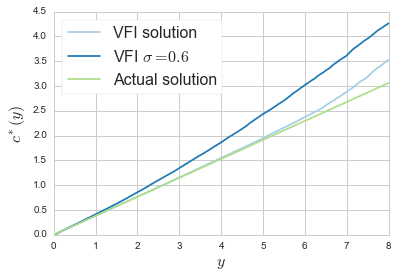

In [20]:
plt.plot(grid,sigma, label='VFI solution')
plt.plot(grid,sigma2, label='VFI $\sigma = 0.6$')
plt.plot(grid, (1-pamdic["beta"]*pamdic["alpha"])*grid, label="Actual solution")
plt.xlabel('$y$', fontsize=16)
plt.ylabel("$c^*(y)$", fontsize=16)
plt.legend(loc='best', fontsize=16, frameon=True)
plt.show()

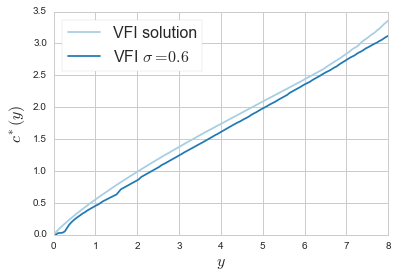

In [21]:
plt.plot(grid,sigma3, label='VFI solution')
plt.plot(grid,sigma4, label='VFI $\sigma = 0.6$')
plt.xlabel('$y$', fontsize=16)
plt.ylabel("$c^*(y)$", fontsize=16)
plt.legend(loc='best', fontsize=16, frameon=True)
plt.show()